# Compressing Feature Space For Classification Using PCA

In this project we use Principal Component Analysis (PCA) to compress 100 unlabelled, sparse features into a more manageable number for classiying buyers of Ed Sheeran’s latest album.

## Project Overview

### Context

Our client is looking to promote Ed Sheeran’s new album - and want to be both targeted with their customer communications, and as efficient as possible with their marketing budget.

As a proof-of-concept they would like us to build a classification model for customers who purchased Ed’s last album based upon a small sample of listening data they have acquired for some of their customers at that time.

If we can do this successfully, they will look to purchase up-to-date listening data, apply the model, and use the predicted probabilities to promote to customers who are most likely to purchase.

The sample data is short but wide. It contains only 356 customers, but for each, columns that represent the percentage of historical listening time allocated to each of 100 artists. On top of these, the 100 columns do not contain the artist in question, instead being labelled artist1, artist2 etc.

We will need to compress this data into something more manageable for classification!

### Actions

We firstly needed to bring in the required data, both the historical listening sample, and the flag showing which customers purchased Ed Sheeran’s last album. We ensure we split our data a training set & a test set, for classification purposes. For PCA, we ensure that we scale the data so that all features exist on the same scale.

We then apply PCA without any specified number of components - which allows us to examine & plot the percentage of explained variance for every number of components. Based upon this we make a call to limit our dataset to the number of components that make up 75% of the variance of the initial feature set (rather than limiting to a specific number of components). We apply this rule to both our training set (using fit_transform) and our test set (using transform only)

With this new, compressed dataset, we apply a Random Forest Classifier to predict the sales of the album, and we assess the predictive performance!

## Data Overview

Our dataset contains only 356 customers, but 102 columns.

In the code below, we:

- Import the required python packages & libraries
- Import the data from the database
- Drop the ID column for each customer
- Shuffle the dataset
- Analyse the class balance between album buyers, and non album buyers

### Import Required Packages

In [5]:
# import required Python packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

### Import Data

In [7]:
# import data
data_for_model = data_for_model = pd.read_csv(open("data/sample_data_pca.csv"))

# drop the id column
data_for_model.drop("user_id", axis = 1, inplace = True)

# shuffle the data
data_for_model = shuffle(data_for_model, random_state = 42)

# analyse the class balance
data_for_model["purchased_album"].value_counts(normalize = True)

purchased_album
1    0.533708
0    0.466292
Name: proportion, dtype: float64

From the last step in the above code, we see that 53% of customers in our sample did purchase Ed’s last album, and 47% did not. Since this is evenly balanced, we can most likely rely solely on Classification Accuracy when assessing the performance of the classification model later on.

After these steps, we have a dataset that looks like the below sample (not all columns shown):

In [9]:
data_for_model.head()

,purchased_album,artist1,artist2,artist3,artist4,artist5,artist6,artist7,artist8,artist9,...,artist91,artist92,artist93,artist94,artist95,artist96,artist97,artist98,artist99,artist100
227,1,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,...,0.0000,0.0045,0.0,0.2887,0.0,0.0000,0.0000,0.0000,0.0136,0.0000
42,1,0.0278,0.0,0.0000,0.0000,0.0,0.0036,0.0002,0.0,0.0,...,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.1894,0.0000,0.0000,0.0000
256,1,0.0000,0.0,0.0367,0.0053,0.0,0.0000,0.0367,0.0,0.0,...,0.0000,0.0002,0.0,0.0002,0.0,0.0001,0.0000,0.0243,0.0000,0.0005
182,1,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,...,0.0000,0.0000,0.0,0.0000,0.0,0.0011,0.8431,0.0000,0.0000,0.0000
56,1,0.0007,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,...,0.0011,0.0163,0.0,0.0000,0.0,0.0000,0.0000,0.0179,0.8111,0.0000


The data is at customer level. We have a binary column showing whether the customer purchased the prior album or not, and following that 100 columns containing the percentage of historical listening time allocated to each artist. We do not know the names of these artists.

From the above sample, we can also see the sparsity of the data, customers do not listen to all artists and therefore many of the values are 0.

### PCA Overview

Principal Component Analysis (PCA) is often used as a Dimensionality Reduction technique that can reduce a large set of variables down to a smaller set, that still contains most of the original information.

In other words, PCA takes a high number of dimensions, or variables and boils them down into a much smaller number of new variables - each of which is called a principal component. These new components are somewhat abstract - they are a blend of some of the original features where the PCA algorithm found they were correlated. By blending the original variables rather than just removing them, the hope is that we still keep much of the key information that was held in the original feature set.

Dimensionality Reduction techniques like PCA are mainly used to simplify the space in which we’re operating. Attempting to apply the k-means clustering algorithm (for example) across hundreds or thousands of features can be computationally expensive, PCA reduces this vastly while maintaining much of the key information contained in the data. But PCA doesn’t have applications just within the realms of unsupervised learning, it could just as easily be applied to a set of input variables in a supervised learning approach - exactly like we will do here!

In supervised learning, we often focus on Feature Selection where we look to remove variables that are not deemed to be important in predicting our output. PCA is often used in a similar way, although in this case we aren’t explicitly removing variables - we are simply creating a smaller number of new ones that contain much of the information contained in the original set.

Business consideration of PCA: It is much more difficult to interpret the outputs of a predictive model (for example) that is based upon component values versys the original variables.

### Data Preparation

#### Split Out Data For Modelling

In the next code block we do two things, we firstly split our data into an X object which contains only the predictor variables, and a y object that contains only our dependent variable.

Once we have done this, we split our data into training and test sets to ensure we can fairly validate the accuracy of the predictions on data that was not used in training. In this case, we have allocated 80% of the data for training, and the remaining 20% for validation. We make sure to add in the stratify parameter to ensure that both our training and test sets have the same proportion of customers who did, and did not, sign up for the delivery club - meaning we can be more confident in our assessment of predictive performance.

In [13]:
# split data into X and y objects for modelling
X = data_for_model.drop(["purchased_album"], axis = 1)
y = data_for_model["purchased_album"]

# split out training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

#### Feature Scaling

Feature Scaling is extremely important when applying PCA - it means that the algorithm can successfully “judge” the correlations between the variables and effectively create the principal compenents for us. The general consensus is to apply Standardisation rather than Normalisation.

The below code uses the in-built StandardScaler functionality from scikit-learn to apply Standardisation to all of our variables.

In the code, we use fit_transform for the training set, but only transform to the test set. This means the standardisation logic will learn and apply the “rules” from the training data, but only apply them to the test data. This is important in order to avoid data leakage where the test set learns information about the training data, and means we can’t fully trust model performance metrics!

In [15]:
# create our scaler object
scale_standard = StandardScaler()

# standardise the data
X_train = scale_standard.fit_transform(X_train)
X_test = scale_standard.transform(X_test)

#### Fitting PCA

We firstly apply PCA to our training set without limiting the algorithm to any particular number of components, in other words we’re not explicitly reducing the feature space at this point.

Allowing all components to be created here allows us to examine & plot the percentage of explained variance for each, and assess which solution might work best for our task.

In the code below we instantiate our PCA object, and then fit it to our training set.

In [17]:
# instantiate our PCA object (no limit on components)
pca = PCA(n_components = None,  random_state = 42)

# fit to our training data
pca.fit(X_train)

PCA(random_state=42)

### Analysis Of Explained Variance

There is no right or wrong number of components to use - this is something that we need to decide based upon the scenario we’re working in. We know we want to reduce the number of features, but we need to trade this off with the amount of information we lose.

In the following code, we extract this information from the prior step where we fit the PCA object to our training data. We extract the variance for each component, and we do the same again, but for the cumulative variance. Will will assess & plot both of these in the next step.

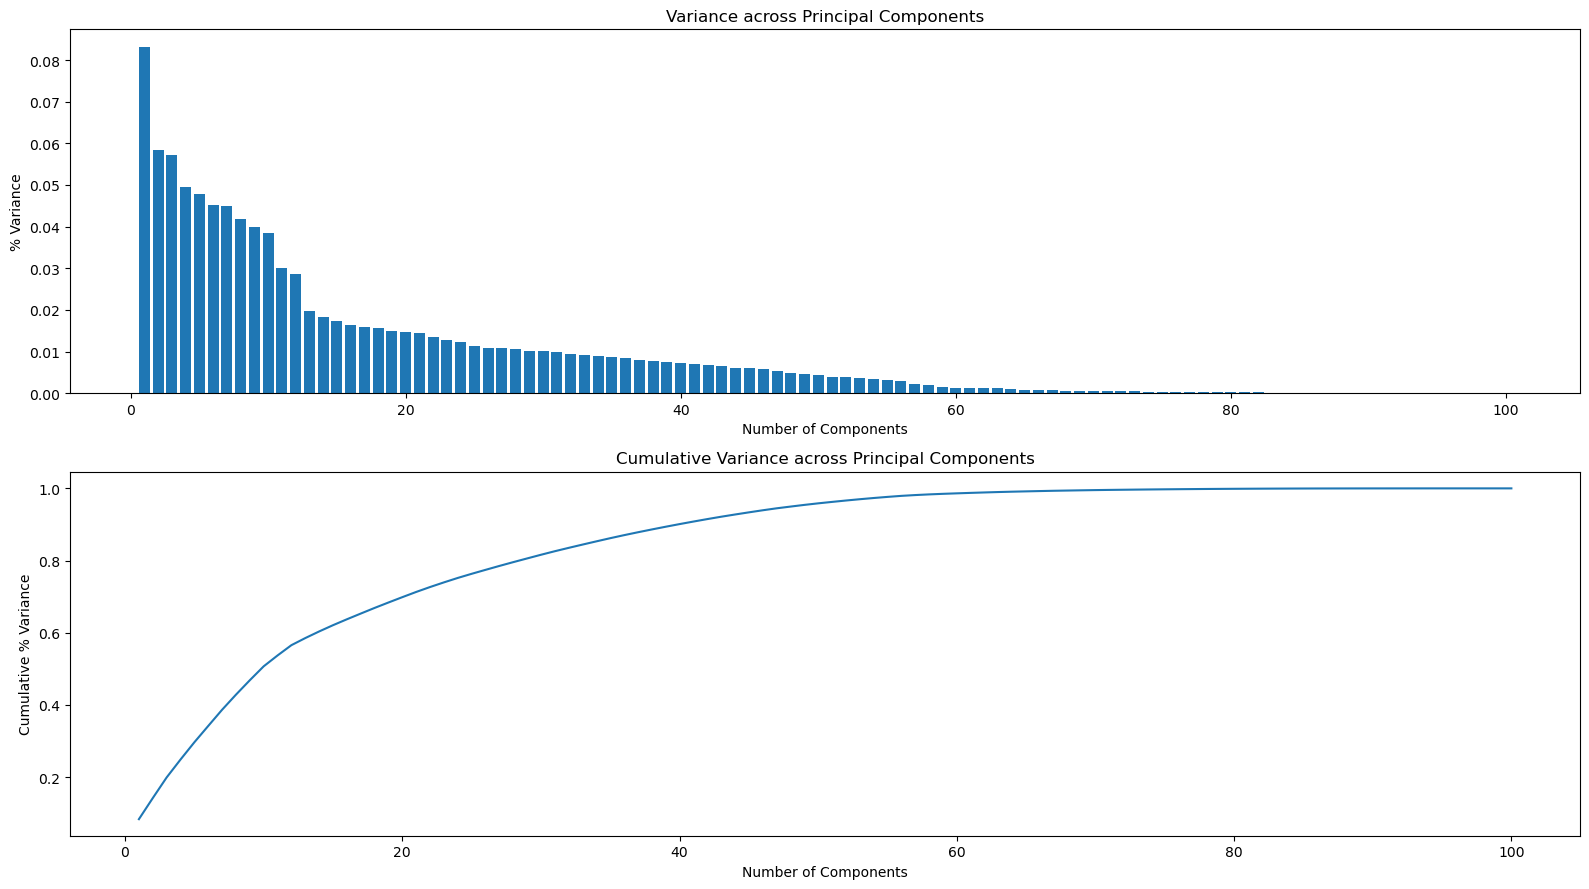

In [19]:
# explained variance across components
explained_variance = pca.explained_variance_ratio_

# explained variance across components (cumulative)
explained_variance_cumulative = pca.explained_variance_ratio_.cumsum()

num_vars_list = list(range(1,101))
plt.figure(figsize=(16,9))

# plot the variance explained by each component
plt.subplot(2,1,1)
plt.bar(num_vars_list,explained_variance)
plt.title("Variance across Principal Components")
plt.xlabel("Number of Components")
plt.ylabel("% Variance")
plt.tight_layout()

# plot the cumulative variance
plt.subplot(2,1,2)
plt.plot(num_vars_list,explained_variance_cumulative)
plt.title("Cumulative Variance across Principal Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative % Variance")
plt.tight_layout()
plt.show()

As we can see in the top plot, PCA works in a way where the first component holds the most variance, and each subsequent component holds less and less.

The second plot shows this as a cumulative measure - and we can how many components we would need remain in order to keep any amount of variance from the original feature set.

Based upon the cumulative plot above, we can see that we could keep 75% of the variance from the original feature set with only around 25 components, in other words with only a quarter of the number of features we can still hold onto around three-quarters of the information.

### Applying our PCA solution

Now we’ve run our analysis of variance by component - we can apply our PCA solution.

In the code below - we re-instantiate our PCA object, this time specifying that we want the number of components that will keep 75% of the initial variance.

We then apply this solution to both our training set (using fit_transform) and our test set (using transform only).

Finally - based on this 75% threshold, we confirm the number of components that this leaves us with.

In [22]:
# re-instantiate our PCA object (keeping 75% of variance)
pca = PCA(n_components = 0.75,  random_state = 42)

# fit to our data
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# check the number of components
print(pca.n_components_)

24


Turns out we were almost correct from looking at our chart - we will retain 75% of the information from our initial feature set, with only 24 principal components.

Our X_train and X_test objects now contain 24 columns, each representing one of the principal components.

### Classification Model

#### Training The Classifier

To start with, we will simply apply a Random Forest Classifier to see if it is possible to predict based upon our set of 24 components.

In the code below we instantiate the Random Forest using the default parameters, and then we fit this to our data.

In [25]:
# instantiate our model object
clf = RandomForestClassifier(random_state = 42)

# fit our model using our training & test sets
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Classification Performance

In the code below we use the trained classifier to predict on the test set - and we run a simple analysis for the classification accuracy for the predictions vs. actuals.

In [27]:
# predict on the test set
y_pred_class = clf.predict(X_test)

# assess the classification accuracy
accuracy_score(y_test, y_pred_class)

0.9305555555555556

The result of this is a 93% classification accuracy, in other words, using a classifier trained on 24 principal components we were able to accurately predict which test set customers purchased Ed Sheeran’s last album, with an accuracy of 93%.

## Application

Based upon this proof-of-concept, we could go back to the client and recommend that they purchase some up to date listening data. We would could apply PCA to this, create the components, and predict which customers are likely to buy Ed’s next album.

## Next Steps

We only tested one type of classifier here (Random Forest) - it would be worthwhile testing others. We also only used the default classifier hyperparameters - we would want to optimise these.

Here, we selected 24 components based upon the fact this accounted for 75% of the variance of the initial feature set. We would instead look to search for the optimal number of components to use based upon classification accuracy.